In [1]:
# Import modules, including the relevant MORTICIA modules
import morticia.rad.librad as librad
import morticia.rad.radute as radute
# Use auto reload of librad for development purposes
%load_ext autoreload
%autoreload 1
%aimport morticia.rad.librad
%aimport morticia.rad.radute
import numpy as np
from scipy.interpolate import interp1d
import matplotlib as mpl
import matplotlib.pyplot as plt
from ipyparallel import Client  # This is the client class for contacting the hub/controller
import ref_index  # For converting air wavelengths to vacuum and vice versa
# For handling dates, times and timezones
import datetime
import pytz
import copy  # Will need to deepcopy some objects
import os
import getpass
import ConfigParser
%matplotlib inline

In [2]:
# Choose and read the scenario configuration
scenario_config_file = 'O2TOA_S3_20160605.ini'
scenario = ConfigParser.ConfigParser()
scenario.read(scenario_config_file)
# Choose and read the ipyparallel compute cluster configuration 
ipyparallel_config_file = 'ipyparallel.ini'
cluster_config = ConfigParser.ConfigParser()
cluster_config.read(ipyparallel_config_file)
# Define a convenience function for reading the scenario parameters
# Note that this function evals the RHS of the definition in the
# .ini file, so that inline comments can be used as well as
# any other Python expression syntax.
def scene(section, item):
    return eval(scenario.get(section, item))
# Print out the scenario file
from pygments import highlight
from pygments.lexers import IniLexer
from pygments.formatters import TerminalTrueColorFormatter
print highlight(open(scenario_config_file, 'rt').read(), 
                IniLexer(), TerminalTrueColorFormatter())

[Case]
# Provide a name and version for the run - will determine output folder
name = 'O2TOA_S3_20160605'
version = '001'
description = 'Simulation run for Sentinel 3 overpass on 2016-06-05'
# The title is what will be used as the heading in the pdf report
title = 'Simulation of atmospheric transmittance and TOA radiance in S3/OLCI bands Oa12 to Oa15'
subtitle = 'RSA Overpass on 2016-06-05'  # Provide a sub-title for the report if desired
author = 'Derek Griffith'

[Output]
# Mostly graphic output controls
use_tex = True  # Use TeX to generate graph labels or not
figsize = (20,10)
font_size = 22
font_family = 'normal'
font_weight = 'bold'
# Use backend figure format 'pdf' when doing nbconvert --to latex
backend_figure_format = 'pdf'  # None for default, otherwise 'pdf' or other graphic format
output_figure_formats = ['pdf', 'png']  # these are the required graphical output formats
# Set the publish item to True in order to produce a pdf report of the run
publish = True

[PlaceTime]
# T

In [3]:
# Reference air conditions - NIST seems to be unclear on exactly what NTP corresponds to
pressureNTP = 101325  # Pa
temperatureNTP = 20  # deg celsius
rel_humidityNTP = 50  # %
co2NTP = 400  # ppm


In [7]:
# Set up viewing and solar geometry.
# Care has to be taken when putting geometry information into libRadtran
scenario.read(scenario_config_file)  # refresh in case it has changed
# Observation azimuth angle (presumably relative to north 
#   through east, satellite from target)
OAA = scene('View', 'OAA')  # deg
# Observation zenith angle (satellite zenith angle as seen from the target)
OZA = scene('View', 'OZA')  # deg
# Solar azimuth angle (presumably relative to north through east)
SAA = scene('Solar', 'SAA')  # deg
# Solar zenith angle
SZA = scene('Solar', 'SZA') # deg. 

# Set up some atmospheric state parameters
# Choose basic atmospheric profile
# NOTE: This profile selection must correspond to the profile used to 
# generate the ARTS molecular extinction data
# If not, the REPTRAN broad-spectrum result will not merge well with 
# the K-line vicinity high-resolution results 
atmos_profile = scene('Atmosphere', 'atmos_profile')
# Precipitable water vapour
water_vapour_col_mm = scene('Atmosphere', 'water_vapour_col_mm')  # mm
# ozone column
ozone_column_du = scene('Atmosphere', 'ozone_column_du')  # dobson units 
rte_solver = scene('RTC', 'rte_solver')
# Altitude of ground (BOA) above mean sea level
ground_altitude = scene('PlaceTime', 'ground_altitude')  # km 

# Use full resolution Kurucz spectrum extract between 755 nm and 780 nm
# This is not used for the transmittance run, but later in the radiance run it will be used
# However, it is used to set the bounds of the wavelength grid file
# A local as well as a compute cluster copy must be available
solar_toa_file = scene('Solar', 'solar_toa_file')

# Choose which Kurucz spectrum to use for the REPTRAN
# broad spectrum, lower-resolution calculations
#solar_toa_file_reptran = '../data/solar_flux/kurudz_0.1nm.dat' 
solar_toa_file_reptran = scene('Solar', 'solar_toa_file_reptran') 

# Set up day of year - but will only be used later in full radiance runs
# Set up dates and times
the_datetime = scene('PlaceTime', 'datetime')
# Overpass date and time down to second
overpass_datetime = datetime.datetime(*the_datetime, tzinfo=pytz.utc)  
overpass_datestr = overpass_datetime.strftime('%Y%m%d')
# Get the day of year
day_of_year = int(overpass_datetime.strftime('%j'))

# Set up aerosol-related data

# Will either use angstrom law or King-Byrne law fitted to MicroTOPS measurements,
# or (if aerosol_haze is specified) a canned Shettle/Fenn aerosol

# Set up aerosols above 2 km - above background conditions
# are mainly driven by large volcanic eruptions 
aerosol_vulcan = librad.shettle_aerosol_vulcan[scene('Atmosphere', 'shettle_aerosol_vulcan')]
# Shettle/Fenn aerosol character, this will overide  
# angstrom law or King-byrne law if not None
aerosol_haze = librad.shettle_aerosol_haze[scene('Atmosphere', 'shettle_aerosol_haze')]
# Aerosol seasonal modification only applies if Shettle/Fenn aerosol is used
aerosol_season = librad.shettle_aerosol_season[scene('Atmosphere', 'shettle_aerosol_season')]  
aerosol_visibility = scene('Atmosphere', 'aerosol_visibility')  # km
if aerosol_visibility is None:
    # Get the AOT data
    aerosol_aot_data = np.array(scene('Atmosphere','aerosol_aot_data'))
    aot_wv = aerosol_aot_data[0, :]  # e.g. MicroTOPS measurement wavelengths
    aot = aerosol_aot_data[1, :]  # e.g. MicroTOPS measurements    
    # Calculate visibility using the aot data and the Koschmieder relationship
    aerosol_model = scene('Atmosphere', 'aerosol_model')
    boundary_layer_height = scene('Atmosphere', 'boundary_layer_height')  # km
    if aerosol_model == 'king-byrne':
        # Fit King Byrne formula
        alpha_0, alpha_1, alpha_2 = librad.king_byrne_formula_fit(aot_wv, aot)
        aot_550 = librad.king_byrne_formula(550.0, alpha_0, alpha_1, alpha_2)
    elif aerosol_model == 'angstrom':
        # Fit Angstrom law to data
        alpha, beta = librad.angstrom_law_fit(aot_wv, aot)        
        aot_550 = librad.angstrom_law(550.0, alpha, beta)    
    aerosol_visibility = librad.koschmieder_vis(aot_550=aot_550, 
                                                    scale_height=boundary_layer_height)
    print 'AOT at 550 nm : ', '%6.3f' % (aot_550) 
print 'Visibility : ', '%6.3f %s' % (aerosol_visibility, 'km')


AOT at 550 nm :   0.532
Visibility :   7.198 km


In [8]:
# Set up atmospheric model and base case
atm = librad.Case(casename='AtmModelForS3O2')

atm.set_option('atmosphere_file', atmos_profile)  # mid-latitude summer etc.

# Modify the ozone and water vapour column amounts
# Total water vapour column in mm
atm.set_option('mol_modify H2O', water_vapour_col_mm, 'MM') 
# Total ozone column in Dobson units
atm.set_option('mol_modify O3', ozone_column_du, 'DU')  

# Choose solver
atm.set_option('rte_solver', rte_solver)

# Set ground altitude (BOA) above sea-level
atm.set_option('altitude', ground_altitude)  # km AMSL

# Set up aerosol model
# Aerosol type above 2km
atm.set_option('aerosol_default')
if aerosol_vulcan:
    atm.set_option('aerosol_vulcan', aerosol_vulcan)  

# If the aerosol_haze is set, it takes precedence over Angstrom or King-byrne    
if aerosol_haze:
    atm.set_option('aerosol_haze', aerosol_haze)  # Shettle/Fenn urban aerosol
    if aerosol_season:
        atm.set_option('aerosol_season', aerosol_season)
    if aerosol_visibility:
        atm.set_option('aerosol_visibility', aerosol_visibility)  # Visibility in km      
elif alpha and beta:  # Angstrom is next in precedence
    atm.set_option('aerosol_angstrom', alpha, beta)
elif alpha_0 and alpha_1 and alpha_2:
    # Finally use King-Byrne if parameters are provided
    atm.set_option('aerosol_king_byrne', alpha_0, alpha_1, alpha_2)

In [9]:
# Create a case to compute atmospheric transmittance 
atm_xmitO2 = copy.deepcopy(atm)  # Get the atmospheric basics
atm_xmitO2.name = 'O2LineVicinityPathTransmittance'
# Load up the ARTS line-by-line data
# Atmospheric absorption data - must correspond with the atmospheric profile 
# selection
mol_tau_file = scene('RTC', 'mol_tau_file')
atm_xmitO2.set_option('mol_tau_file abs', mol_tau_file)

# The mol_tau_file should set the internal computational grid, but still need 
# something to set the output grid
# Use full resolution Kurucz spectrum extract between 755 nm and 780 nm
atm_xmitO2.set_option('source solar', solar_toa_file)


# Will use transmittance mode (the reason that no solar file is required)
atm_xmitO2.set_option('output_quantity transmittance')

# Set the solar zenith angle to the observation zenith angle 
# (yes, that is correct for the transmittance run !)
atm_xmitO2.set_option('sza', OZA)

# Set the wavelength range for the computation
wvl_startO2 = 757.5
wvl_stopO2 = 771.5
wvl_step = np.array(0.001)  # nm This is the step size for hi resolution calculation

wv_minimum_range = [[wvl_startO2, -0.002], [wvl_stopO2, 0.002]]
# Find the nearest wavelengths in the solar file, just to maintain consistency 
# of the wavelength grid
# for all steps in the computation, including the later radiance runs.
# Lookup wavelengths in local copy of solar TOA file
wvl_rangeO2 = librad.lookup_nearest_in_file('./KuruczSolarFlux/' + solar_toa_file, wv_minimum_range)  
# Need to ensure that wvl_rangeO2[0] and wvl_rangeO2[-1] are both in the wavelength grid file
wvl_gridO2 = np.hstack((wvl_rangeO2[0], np.arange(wvl_startO2, wvl_stopO2, wvl_step), 
                        wvl_rangeO2[1]))
# Set wavelength grid up in the file
atm_xmitO2.set_wavelength_grid(wvl_gridO2)

# Setting the purge flag to false will inhibit deleting of
# the input and output files written when uvspec runs on
# the target machine (which may not be the local machine).
atm_xmitO2.purge = False  

print atm_xmitO2
print wvl_rangeO2

atmosphere_file midlatitude_summer
mol_modify H2O 10.5 MM
mol_modify O3 266.1 DU
rte_solver disort
altitude 1.225
aerosol_default 
aerosol_vulcan 1
aerosol_haze 5
aerosol_season 1
aerosol_visibility 7.19848881065
mol_tau_file abs ../examples/moltauKLines56fa5f13.nc
source solar kurucz_full_757nm_773nm.dat
output_quantity transmittance
sza 14.151356
wavelength_grid_file O2LineVicinityPathTransmittance_wvl_grid.dat
[ 757.4968433  771.5020677]


In [10]:
# Create the ipyparallel client and contact the hub/controller using the 
# relevant profile and SSH to the machine at the given IP address
# This will cause ipyparallel to look in ~/.ipython/profile_icebow/security 
# for a file named ipcontroller_client.json.
# This file is generated by the hub/controller process when started using 
# the ipcluster or ipcontroller command and it may need to be copied from 
# the host running the hub/controller to the machine running the client.
#
# When the ipcontroller is restarted, it helps to use ipcontroller --reuse 
# to avoid overwriting the .json files and the requirement to copy the 
# new .json files to the compute client machine(s).

# Set up cluster controller host
# Re-read .ini file in case anythong has changed
cluster_config.read(ipyparallel_config_file)
cluster_profile = cluster_config.get('Cluster', 'profile')
host_sshserver = cluster_config.get('Cluster', 'sshserver')
host_password = cluster_config.get('Cluster', 'password')

# Get the password directly from the user if not in the .ini file
try:
    if not host_password:
        host_password = getpass.getpass('Password for ' + host_sshserver + ' :')
except NameError:
    host_password = getpass.getpass('Password for ' + host_sshserver + ' :')

Password for dgriffith@f2.csir.co.za :········


In [11]:
paraclient = Client(profile=cluster_profile, sshserver=host_sshserver, 
                    password=host_password)
number_of_processes = cluster_config.getint('Cluster', 'number_of_processes')
# Obtain a "load-balanced" view of the engine cluster
paraview = paraclient.load_balanced_view()
# Set the view to blocking mode, which means that we wait for all engines 
# to complete the task before control is returned to the client
paraview.block = True
# We will use dill instead of the standard pickle so that we can send 
# instance methods to engines
paraclient[:].use_dill()

<AsyncResult: use_dill>

In [12]:

# Create function to check on success of a list of libRadtran/uvspec runs
# Just raise a runtime error if any of the runs has failed.
def check_uvspec_run_success(runlist):
    run_return_codes = [case.run_return_code for case in runlist]
    # Print standard error outputs for failed runs
    if any(run_return_codes):
        print 'One or more libRadtran/uvspec runs failed. '
        print 'Please review standard error output.'
        print [case.stderr for case in runlist if case.run_return_code]
        raise RuntimeError
    else:
        print 'All runs successful.' 

In [13]:
# Now try to run the batch on the cluster
run_list = paraview.map(librad.Case.run, [atm_xmitO2])
# Check that all runs were successful using the utility function
# defined at the top of this notebook
check_uvspec_run_success(run_list)

All runs successful.


In [14]:
# Extract the relevant data 
atm_xmitO2_case = run_list[0]
# Also convert from vacuum to air wavelengths
wvl_xmitO2 = ref_index.vac2air(atm_xmitO2_case.wvl[0:], t=temperatureNTP, 
                    p=pressureNTP, rh=rel_humidityNTP, co2=co2NTP)
atm_xmitO2 = atm_xmitO2_case.edir[0:,0]

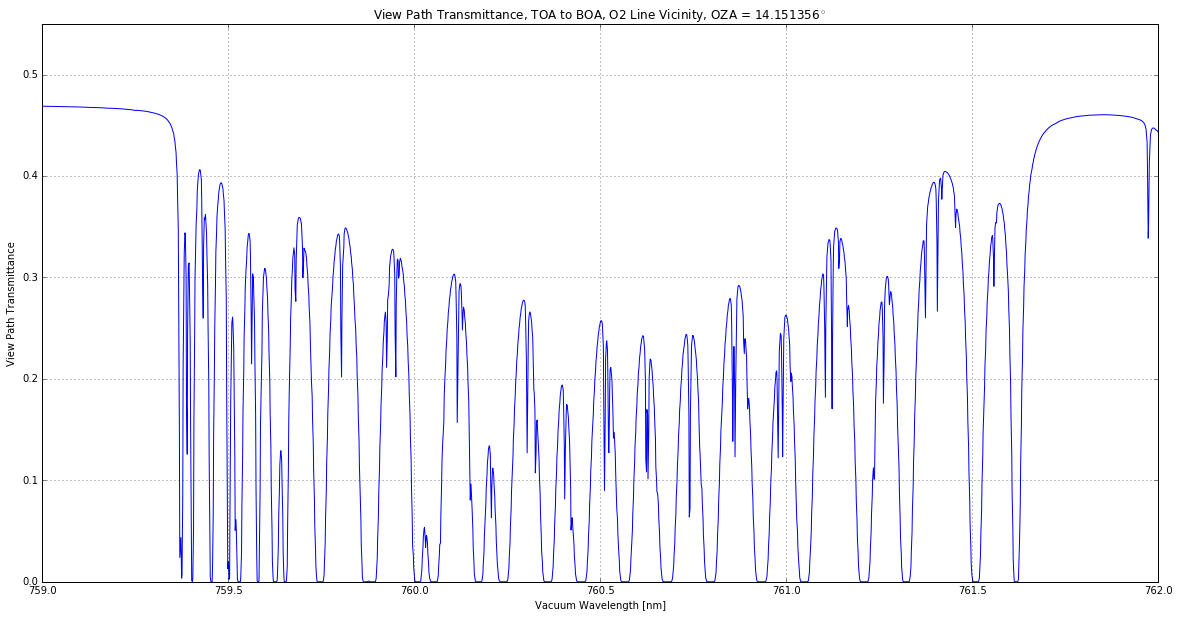

In [15]:
# Plot path transmittance near O2
plt.figure(figsize=(20,10))
plt.plot(wvl_xmitO2, atm_xmitO2)
plt.xlabel('Vacuum Wavelength [nm]')
plt.ylabel('View Path Transmittance')
plt.title('View Path Transmittance, TOA to BOA, O2 Line Vicinity, OZA = ' + str(OZA) + 
          '$^\circ$')
plt.xlim([wvl_startO2, wvl_stopO2])
plt.ylim([0.0, 0.55])
plt.xlim([759, 762])
#plt.axvline(x=wvlO2vac, color='r')
plt.grid()

plt.savefig('ViewPathTransmittanceO2.pdf')

In [16]:
# Load up the SRFs of S3/OLCI

s3olci_srf = radute.Flt(name='./data/Sentinel3/Sentinel3SRF2011Cam4.flt')
# Will only be dealing with bands 12 to 15
olci_bands = ['Oa12', 'Oa13', 'Oa14', 'Oa15', 'Oa16']

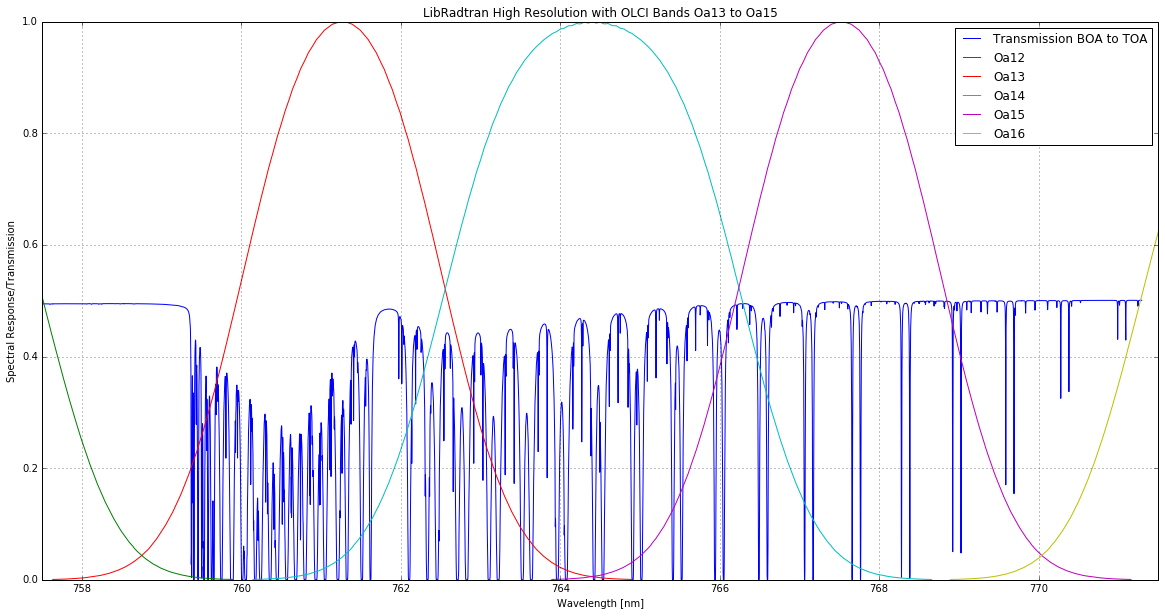

In [128]:
plt.figure(figsize=(20,10))
plt.hold(True)
plt.plot(wvl_xmitO2, atm_xmitO2)
s3olci_srf.plot(filter_numbers=[11,12,13,14,15])
plt.xlim([757.5, 771.5])
plt.legend(['Transmission BOA to TOA'] + olci_bands)
plt.title('LibRadtran High Resolution with OLCI Bands Oa13 to Oa15')
plt.grid(True)
plt.savefig('./data/Sentinel3/HiResWithOLCIOa13to15.pdf')

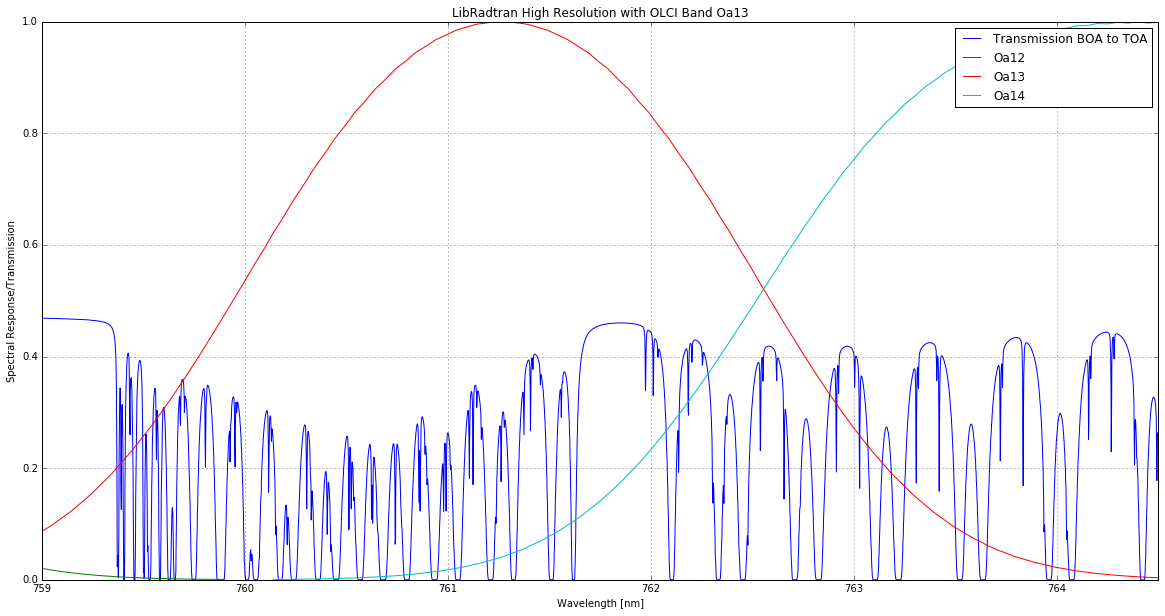

In [17]:
plt.figure(figsize=(20,10))
plt.hold(True)
plt.plot(wvl_xmitO2, atm_xmitO2)
s3olci_srf.plot(filter_numbers=[11,12,13])
plt.xlim([759, 764.5])
plt.legend(['Transmission BOA to TOA'] + olci_bands[0:3])
plt.title('LibRadtran High Resolution with OLCI Band Oa13')
plt.grid(True)
plt.savefig('./data/Sentinel3/HiResWithOLCIOa13.pdf')

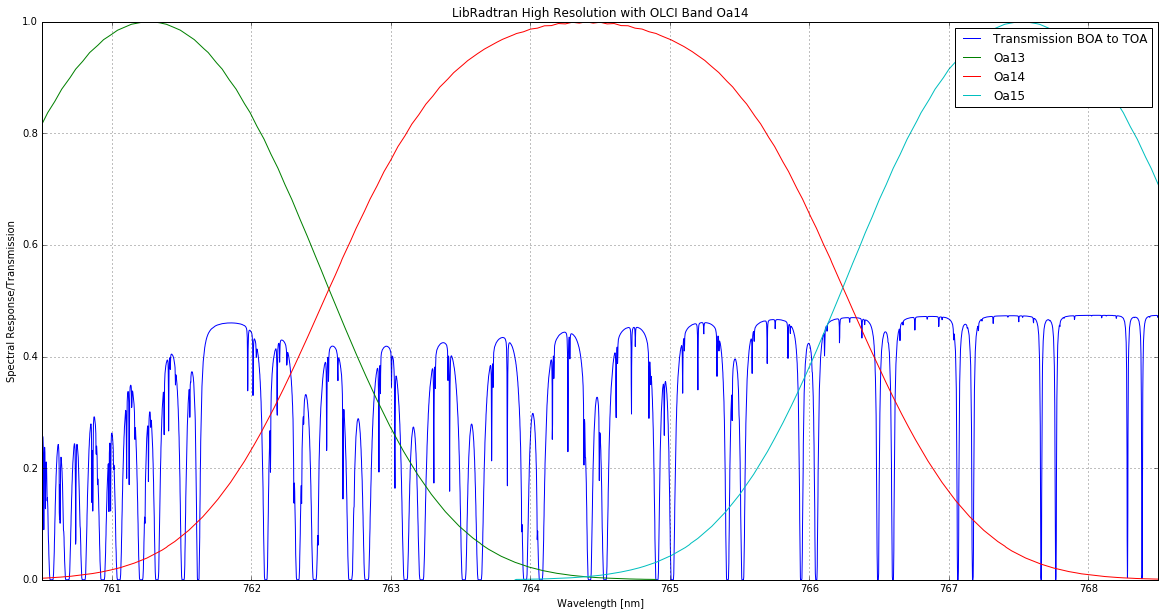

In [18]:
plt.figure(figsize=(20,10))
plt.hold(True)
plt.plot(wvl_xmitO2, atm_xmitO2)
s3olci_srf.plot(filter_numbers=[12,13,14])
plt.xlim([760.5, 768.5])
plt.legend(['Transmission BOA to TOA'] + olci_bands[1:4])
plt.title('LibRadtran High Resolution with OLCI Band Oa14')
plt.grid(True)
plt.savefig('./data/Sentinel3/HiResWithOLCIOa14.pdf')

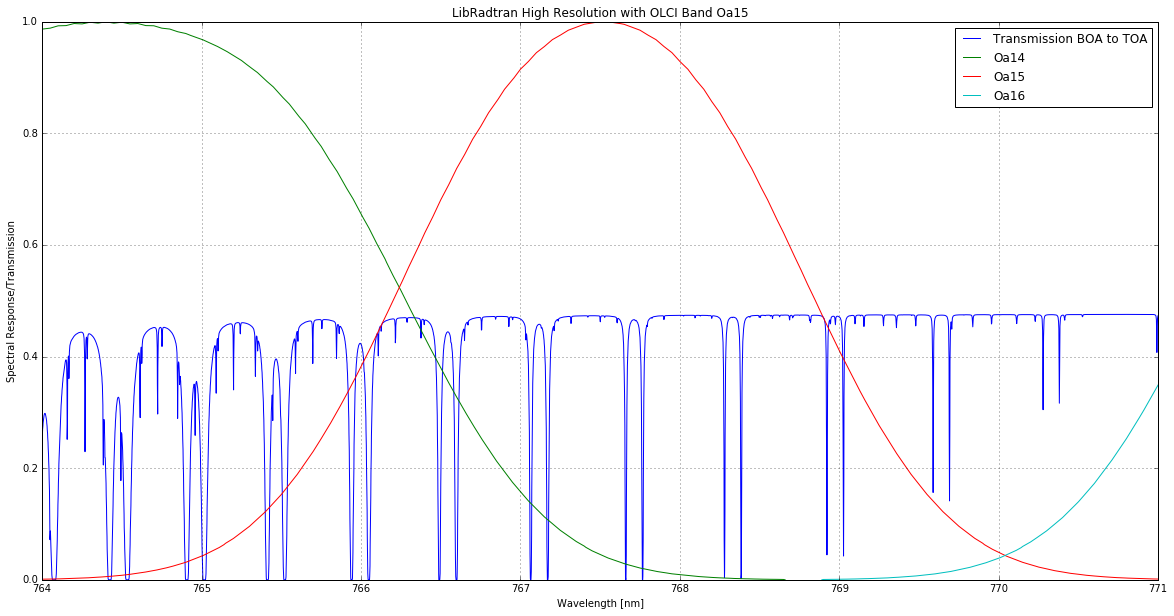

In [19]:
plt.figure(figsize=(20,10))
plt.hold(True)
plt.plot(wvl_xmitO2, atm_xmitO2)
s3olci_srf.plot(filter_numbers=[13,14,15])
plt.xlim([764, 771])
plt.legend(['Transmission BOA to TOA'] + olci_bands[2:])
plt.title('LibRadtran High Resolution with OLCI Band Oa15')
plt.grid(True)
plt.savefig('./data/Sentinel3/HiResWithOLCIOa15.pdf')

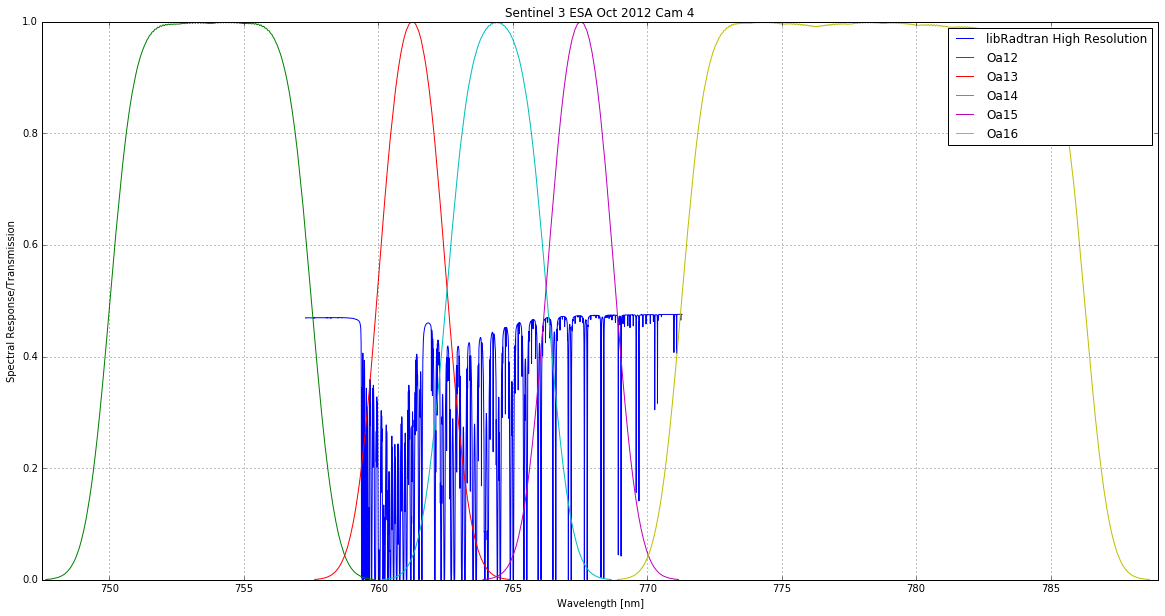

In [20]:
plt.figure(figsize=(20,10))
plt.hold(True)
plt.plot(wvl_xmitO2, atm_xmitO2)
s3olci_srf.plot(filter_numbers=[11,12,13,14,15])
plt.xlim([747.5, 789.0])
plt.legend(['libRadtran High Resolution'] + olci_bands)
plt.grid(True)
plt.savefig('./data/Sentinel3/HiResWithOLCIOa12to16.pdf')

In [21]:
# Run REPTRAN over the range of 747.5 to 789.0
# For broad spectrum work at lower resolution, will use REPTRAN
scenario.read(scenario_config_file)  # refresh in case it has changed
reptran_resolution = scene('RTC', 'reptran_resolution')  # coarse, medium or fine
wvl_broad_start = scene('RTC', 'wvl_broad_start')  # nm  broad spectrum start wavelength
wvl_broad_stop = scene('RTC', 'wvl_broad_stop')  # nm  broad spectrum setop wavelength
# Next create transmittance cases at lower spectral resolution
# The high spectral resolution data will be spliced into the lower resolution data 
atm_xmit = copy.deepcopy(atm)
atm_xmit.name = 'FullSpectrumPathTransmittance'

# Will use reptran and source solar
atm_xmit.set_option('mol_abs_param reptran', reptran_resolution)
atm_xmit.set_option('source solar', solar_toa_file_reptran)

# Will use transmittance mode (the reason that no solar file is required)
atm_xmit.set_option('output_quantity transmittance')

atm_xmit.set_option('wavelength', wvl_broad_start, wvl_broad_stop)

# Set the solar zenith angle to the observation zenith angle (yes, that is correct 
# for the transmittance run)
atm_xmit.set_option('sza', OZA)

In [22]:
# Split up into number of sub-cases depending on the number of cores and 
# other factors on the compute cluster
atm_xmit_list = atm_xmit.split_case_by_wavelength(number_of_processes, 
                                    overlap=1.0)  # use wavelength overlap of 1.0 nm

In [23]:
# Take a look at first two
print atm_xmit_list[0], '\n\n', atm_xmit_list[1]

atmosphere_file midlatitude_summer
mol_modify H2O 10.5 MM
mol_modify O3 266.1 DU
rte_solver disort
altitude 1.225
aerosol_default 
aerosol_vulcan 1
aerosol_haze 5
aerosol_season 1
aerosol_visibility 7.19848881065
mol_abs_param reptran fine
source solar ../data/solar_flux/kurudz_0.1nm.dat
output_quantity transmittance
wavelength 746.0 757.0
sza 14.151356 

atmosphere_file midlatitude_summer
mol_modify H2O 10.5 MM
mol_modify O3 266.1 DU
rte_solver disort
altitude 1.225
aerosol_default 
aerosol_vulcan 1
aerosol_haze 5
aerosol_season 1
aerosol_visibility 7.19848881065
mol_abs_param reptran fine
source solar ../data/solar_flux/kurudz_0.1nm.dat
output_quantity transmittance
wavelength 756.0 768.0
sza 14.151356


In [24]:
# Now try to run the batch on the cluster
atm_xmit_list = paraview.map(librad.Case.run, atm_xmit_list)
check_uvspec_run_success(atm_xmit_list)

All runs successful.


In [25]:
# Merge results for edir, which will be direct (specular) transmittance 
# in 'output transmittance' mode
wvl_atm_xmt_reptran_vac, atm_xmit_reptran = \
    librad.Case.merge_caselist_by_wavelength(atm_xmit_list, 'edir')
wvl_atm_xmt_reptran = ref_index.vac2air(wvl_atm_xmt_reptran_vac, t=temperatureNTP, 
                    p=pressureNTP, rh=rel_humidityNTP, co2=co2NTP)

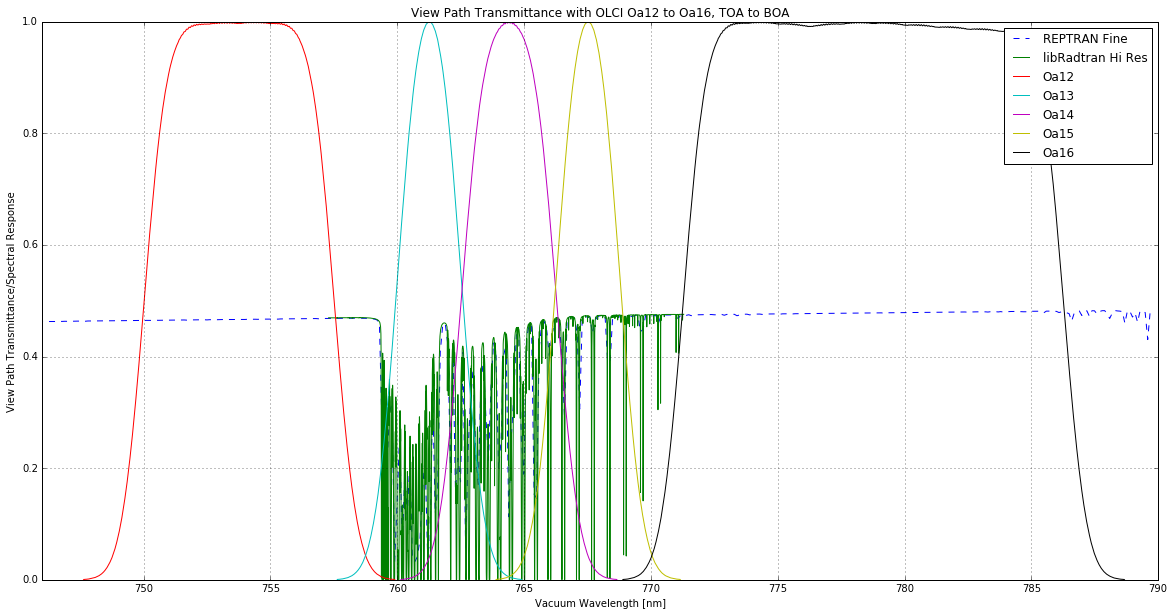

In [26]:
plt.figure(figsize=(20,10))
plt.hold(True)
plt.plot(wvl_atm_xmt_reptran, atm_xmit_reptran, linestyle='--')
plt.plot(wvl_xmitO2, atm_xmitO2)
s3olci_srf.plot(filter_numbers=[11,12,13,14,15])
plt.xlabel('Vacuum Wavelength [nm]')
plt.ylabel('View Path Transmittance/Spectral Response')
plt.title('View Path Transmittance with OLCI Oa12 to Oa16, TOA to BOA')

plt.ylim([0.0, 1.0])
plt.xlim([wvl_broad_start, wvl_broad_stop])

plt.legend(['REPTRAN ' + reptran_resolution.title(), 'libRadtran Hi Res'] + olci_bands)
plt.grid(True)
plt.savefig('./data/Sentinel3/ReptranAndHiResWithOLCI.pdf')

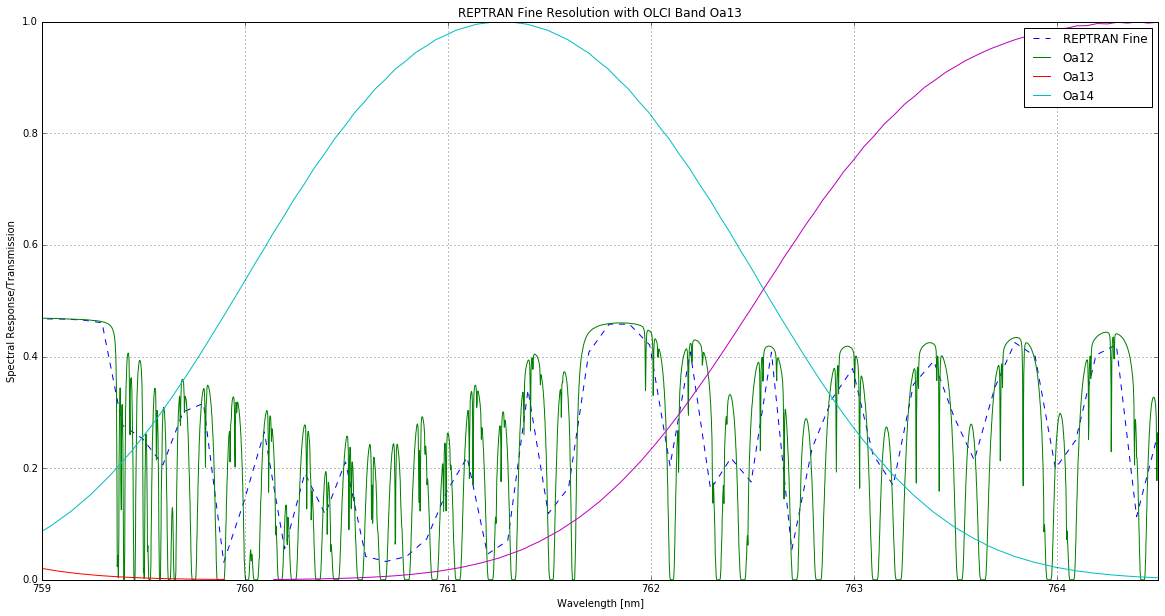

In [28]:
plt.figure(figsize=(20,10))
plt.hold(True)
plt.plot(wvl_atm_xmt_reptran, atm_xmit_reptran, linestyle='--')
plt.plot(wvl_xmitO2, atm_xmitO2)
s3olci_srf.plot(filter_numbers=[11,12,13])
plt.xlim([759, 764.5])
plt.legend(['REPTRAN Fine'] + olci_bands[0:3])
plt.title('REPTRAN Fine Resolution with OLCI Band Oa13')
plt.grid(True)
plt.savefig('./data/Sentinel3/ReptranFineWithOLCIOa13.pdf')